### 0.7834

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


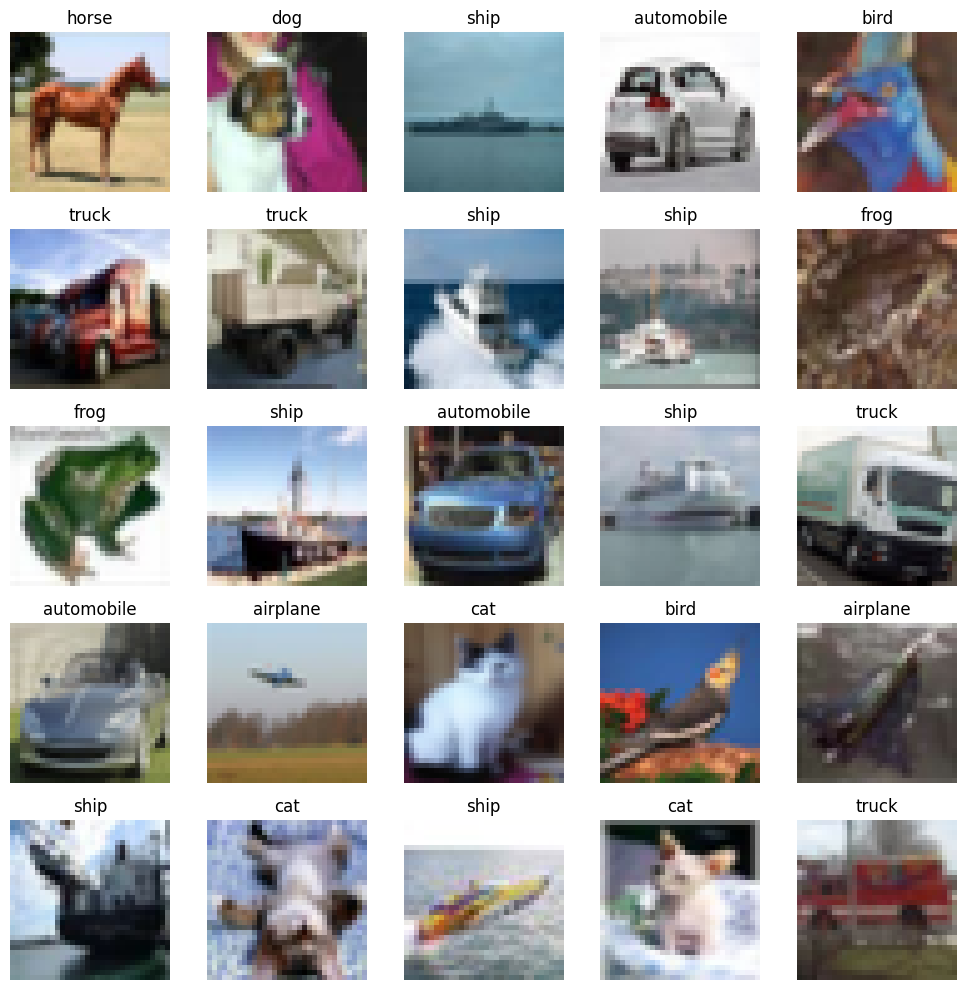

In [5]:
plt.figure(figsize=(10, 10))
for i in range(25):
    idx = np.random.randint(0, len(x_train))
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[idx])
    plt.title(class_names[np.argmax(y_train[idx])])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [3]:
def create_model(base_model_type='vgg16', optimizer='adam', learning_rate=0.001,
                 activation='relu', trainable=False):
    input_tensor = Input(shape=(32, 32, 3))
    if base_model_type == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    elif base_model_type == 'mobilenet':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
    else:
        raise ValueError("지원하지 않는 모델.")

    base_model.trainable = trainable
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation=activation)(x)
    output = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError("지원하지 않는 optimizer.")

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [4]:
def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.5
    return lr

callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    LearningRateScheduler(lr_schedule)
]


In [11]:
wrapped_model = KerasClassifier(
    model=create_model,
    epochs=10,
    batch_size=64,
    verbose=1
)


In [12]:
param_dist = {
    'model__optimizer': ['adam', 'sgd'],
    'model__learning_rate': [0.001, 0.0001],
    'model__activation': ['relu', 'tanh'],
    'model__base_model_type': ['vgg16', 'mobilenet'],
    'model__trainable': [False, True]
}


In [11]:
!pip install scikit-learn==1.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.3.1 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [13]:
search = RandomizedSearchCV(
    estimator=wrapped_model,
    param_distributions=param_dist,
    n_iter=4,
    cv=3,
    verbose=2
)

search.fit(x_train, y_train)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


<ipython-input-3-913824cb12fd>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


521/521 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.1819 - loss: 2.2237
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2866 - loss: 2.0249
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2979 - loss: 1.9607
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3064 - loss: 1.9286
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3114 - loss: 1.9084
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3162 - loss: 1.8983
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3150 - loss: 1.8948
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3192 - loss: 1.8839
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3212 - loss: 1.8791
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3219 - loss: 1.8816


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(64, 32, 32, 3))
  warnings.warn(msg)


257/261 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
[CV] END model__activation=tanh, model__base_model_type=mobilenet, model__learning_rate=0.0001, model__optimizer=adam, model__trainable=False; total time= 1.1min


<ipython-input-3-913824cb12fd>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_245']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


521/521 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.2003 - loss: 2.2146
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2872 - loss: 2.0150
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3015 - loss: 1.9577
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3108 - loss: 1.9205
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3159 - loss: 1.9078
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3179 - loss: 1.8944
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3223 - loss: 1.8920
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3211 - loss: 1.8841
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3218 - loss: 1.8883
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3240 - loss: 1.8756


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_245']
Received: inputs=Tensor(shape=(64, 32, 32, 3))
  warnings.warn(msg)


257/261 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_245']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
[CV] END model__activation=tanh, model__base_model_type=mobilenet, model__learning_rate=0.0001, model__optimizer=adam, model__trainable=False; total time= 1.1min


<ipython-input-3-913824cb12fd>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_402']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


521/521 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.1880 - loss: 2.2217
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2872 - loss: 2.0146
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3016 - loss: 1.9548
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3041 - loss: 1.9266
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3121 - loss: 1.9051
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3215 - loss: 1.8911
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3172 - loss: 1.8918
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3228 - loss: 1.8747
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3252 - loss: 1.8702
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3238 - loss: 1.8675


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_402']
Received: inputs=Tensor(shape=(64, 32, 32, 3))
  warnings.warn(msg)


255/261 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_402']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


261/261 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step
[CV] END model__activation=tanh, model__base_model_type=mobilenet, model__learning_rate=0.0001, model__optimizer=adam, model__trainable=False; total time= 1.1min


<ipython-input-3-913824cb12fd>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_559']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


521/521 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.4354 - loss: 1.6585
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6890 - loss: 0.9217
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7443 - loss: 0.7613
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7712 - loss: 0.6844
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7599 - loss: 0.7019
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7707 - loss: 0.6761
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7818 - loss: 0.6363
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7445 - loss: 0.7605
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7612 - loss: 0.6864
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7960 - loss: 0.5924


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_559']
Received: inputs=Tensor(shape=(64, 32, 32, 3))
  warnings.warn(msg)


258/261 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_559']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
[CV] END model__activation=relu, model__base_model_type=mobilenet, model__learning_rate=0.001, model__optimizer=adam, model__trainable=True; total time= 2.8min


<ipython-input-3-913824cb12fd>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_716']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


521/521 ━━━━━━━━━━━━━━━━━━━━ 70s 48ms/step - accuracy: 0.4428 - loss: 1.6643
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.6985 - loss: 0.8941
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7594 - loss: 0.7195
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7826 - loss: 0.6497
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8031 - loss: 0.5824
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8109 - loss: 0.5579
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8348 - loss: 0.4974
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8440 - loss: 0.4575
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8453 - loss: 0.4624
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8638 - loss: 0.4055


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_716']
Received: inputs=Tensor(shape=(64, 32, 32, 3))
  warnings.warn(msg)


254/261 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_716']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step
[CV] END model__activation=relu, model__base_model_type=mobilenet, model__learning_rate=0.001, model__optimizer=adam, model__trainable=True; total time= 3.5min


<ipython-input-3-913824cb12fd>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_873']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


521/521 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - accuracy: 0.4259 - loss: 1.6950
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.6848 - loss: 0.9465
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7316 - loss: 0.7993
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7689 - loss: 0.6956
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7624 - loss: 0.7113
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8098 - loss: 0.5719
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8308 - loss: 0.5136
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8340 - loss: 0.4812
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8483 - loss: 0.4600
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8446 - loss: 0.4725


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_873']
Received: inputs=Tensor(shape=(64, 32, 32, 3))
  warnings.warn(msg)


254/261 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_873']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


261/261 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step
[CV] END model__activation=relu, model__base_model_type=mobilenet, model__learning_rate=0.001, model__optimizer=adam, model__trainable=True; total time= 3.5min
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1030']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


521/521 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.3704 - loss: 1.7936
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.6676 - loss: 0.9617
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.7197 - loss: 0.8065
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.7504 - loss: 0.7165
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.7708 - loss: 0.6608
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.7868 - loss: 0.6162
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.7985 - loss: 0.5791
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8114 - loss: 0.5373
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.8229 - loss: 0.5054
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8360 - loss: 0.4765


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1030']
Received: inputs=Tensor(shape=(64, 32, 32, 3))
  warnings.warn(msg)


258/261 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1030']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
[CV] END model__activation=relu, model__base_model_type=vgg16, model__learning_rate=0.001, model__optimizer=sgd, model__trainable=True; total time= 3.2min
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1052']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


521/521 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.3775 - loss: 1.7554
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.6653 - loss: 0.9480
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.7217 - loss: 0.7978
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.7542 - loss: 0.7093
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.7664 - loss: 0.6586
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.7933 - loss: 0.5976
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.8006 - loss: 0.5704
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.8170 - loss: 0.5263
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8271 - loss: 0.4894
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8370 - loss: 0.4662


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1052']
Received: inputs=Tensor(shape=(64, 32, 32, 3))
  warnings.warn(msg)


260/261 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1052']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
[CV] END model__activation=relu, model__base_model_type=vgg16, model__learning_rate=0.001, model__optimizer=sgd, model__trainable=True; total time= 3.2min
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1074']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


521/521 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3320 - loss: 1.8495
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.6512 - loss: 1.0013
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7120 - loss: 0.8237
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7447 - loss: 0.7346
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7666 - loss: 0.6743
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7838 - loss: 0.6185
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7987 - loss: 0.5754
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8105 - loss: 0.5469
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.8220 - loss: 0.5064
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.8354 - loss: 0.4764


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1074']
Received: inputs=Tensor(shape=(64, 32, 32, 3))
  warnings.warn(msg)


258/261 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1074']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
[CV] END model__activation=relu, model__base_model_type=vgg16, model__learning_rate=0.001, model__optimizer=sgd, model__trainable=True; total time= 3.6min
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1096']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4260 - loss: 1.6281
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5715 - loss: 1.2286
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5957 - loss: 1.1549
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6068 - loss: 1.1167
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6302 - loss: 1.0615
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6408 - loss: 1.0320
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6592 - loss: 0.9847
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6659 - loss: 0.9457
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6757 - loss: 0.9278
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6900 - loss: 0.8895


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1096']
Received: inputs=Tensor(shape=(64, 32, 32, 3))
  warnings.warn(msg)


259/261 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1096']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
[CV] END model__activation=relu, model__base_model_type=vgg16, model__learning_rate=0.001, model__optimizer=adam, model__trainable=False; total time= 1.4min
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1118']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4336 - loss: 1.6186
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5688 - loss: 1.2248
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6010 - loss: 1.1561
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6145 - loss: 1.1091
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6283 - loss: 1.0690
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6423 - loss: 1.0245
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6542 - loss: 0.9924
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6690 - loss: 0.9494
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6736 - loss: 0.9248
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6902 - loss: 0.8892


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1118']
Received: inputs=Tensor(shape=(64, 32, 32, 3))
  warnings.warn(msg)


257/261 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1118']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
[CV] END model__activation=relu, model__base_model_type=vgg16, model__learning_rate=0.001, model__optimizer=adam, model__trainable=False; total time= 1.5min
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1140']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4312 - loss: 1.6148
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5717 - loss: 1.2293
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5975 - loss: 1.1565
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6168 - loss: 1.1057
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6299 - loss: 1.0598
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6424 - loss: 1.0286
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6544 - loss: 0.9879
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6658 - loss: 0.9612
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6717 - loss: 0.9337
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6831 - loss: 0.9115


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1140']
Received: inputs=Tensor(shape=(64, 32, 32, 3))
  warnings.warn(msg)


257/261 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1140']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
[CV] END model__activation=relu, model__base_model_type=vgg16, model__learning_rate=0.001, model__optimizer=adam, model__trainable=False; total time= 1.4min
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1162']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - accuracy: 0.4190 - loss: 1.6556
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.7007 - loss: 0.8562
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7455 - loss: 0.7252
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.7774 - loss: 0.6369
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7902 - loss: 0.5963
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.8073 - loss: 0.5477
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8237 - loss: 0.5084
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8341 - loss: 0.4733
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8420 - loss: 0.4517
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8512 - loss: 0.4246


RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=64, epochs=10, model=<function create_model at 0x799fb884f240>),
                   n_iter=4,
                   param_distributions={'model__activation': ['relu', 'tanh'],
                                        'model__base_model_type': ['vgg16',
                                                                   'mobilenet'],
                                        'model__learning_rate': [0.001, 0.0001],
                                        'model__optimizer': ['adam', 'sgd'],
                                        'model__trainable': [False, True]},
                   verbose=2)

In [14]:
print("Best params:", search.best_params_)
print("Best score:", search.best_score_)


Best params: {'model__trainable': True, 'model__optimizer': 'sgd', 'model__learning_rate': 0.001, 'model__base_model_type': 'vgg16', 'model__activation': 'relu'}
Best score: 0.7908400046327646


In [15]:
best_model = search.best_estimator_.model_
best_model.summary()

y_pred = best_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

test_acc = accuracy_score(y_true_labels, y_pred_labels)
print(f"Test Accuracy: {test_acc:.4f}")


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_16          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,848,588 (56.64 MB)

 Trainable params: 14,848,586 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1162']
Received: inputs=Tensor(shape=(32, 32, 32, 3))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
Test Accuracy: 0.7834


<Figure size 800x800 with 0 Axes>

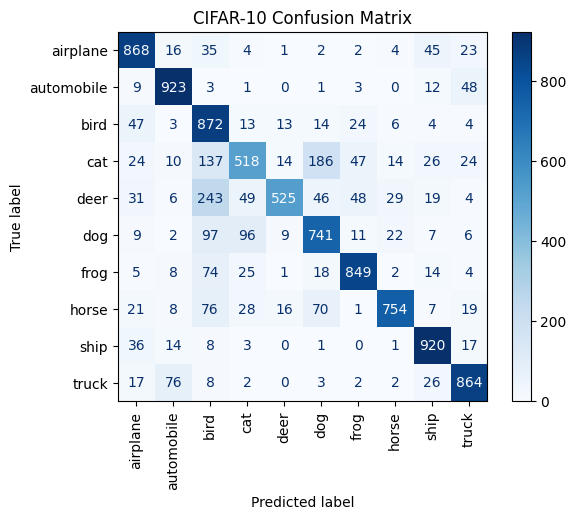

In [16]:
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("CIFAR-10 Confusion Matrix")
plt.show()
